In [2]:
import os
import pandas as pd
import numpy as np

from scipy.stats import hypergeom

import re

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import sci_palettes
sci_palettes.register_cmap()
sns.set_palette('nejm')

# Read data from GWAS Catalog

In [2]:
EFOs = list(set([re_res[0] for file in os.listdir('Data/GWAS_Catalog/') if len(re_res:=re.findall('_(\d+)', file)) != 0]))
EFOs

['0001645', '0003767', '0005090', '0011015']

In [3]:
res = pd.DataFrame()
for EFO in EFOs:
    files = ['Data/GWAS_Catalog/'+file for file in os.listdir('Data/GWAS_Catalog/') if EFO in file]

    df = pd.merge(pd.read_csv(files[0]), pd.read_csv(files[1]), on='Study accession')
    df = df[['Mapped gene', 'P-value', 'Discovery sample number and ancestry', 'Trait(s)_x']].copy()
    df.columns = ['gene', 'pval', 'ancestry', 'trait']
    
#    print(df.trait.value_counts().index[:10])
    df = df[df.trait == df.trait.value_counts().index[0]]
    
    df.pval = df.pval.apply(lambda s: s.replace('-', ' ').split()[0] + 'e-' + s.replace('-', ' ').split()[-1])
    df.pval = df.pval.astype(float)
    df = df[df.pval < 5e-10]

    df.ancestry = df.ancestry.apply(lambda s: 'Asian' if 'asian' in s.lower() else '')\
                            .add(df.ancestry.apply(lambda s: 'European' if 'european' in s.lower() else ''))
    
    df.gene = df.gene.apply(lambda s: '' if (',' in s or ';' in s or ' ' in s) else s)
    df = df[df.gene != '']
#    df.gene = df.gene.apply(lambda s: s.replace(',', ' ').replace(';', ' ').split())
#    df = df[df.gene]
    
    res = pd.concat([res, df])

res

,gene,pval,ancestry,trait
61,ATXN2,8.000000e-14,European,coronary artery disease
62,NAA25,8.000000e-11,European,coronary artery disease
65,GUCY1A1,3.000000e-10,European,coronary artery disease
66,PHACTR1,6.000000e-19,European,coronary artery disease
69,TENT5A,4.000000e-10,European,coronary artery disease
...,...,...,...,...
3724,LINC00358,4.000000e-10,European,self reported educational attainment
3730,ZNF536,3.000000e-10,European,self reported educational attainment
3737,STK4,1.000000e-10,European,self reported educational attainment
3739,CDH4,9.000000e-12,European,self reported educational attainment


In [4]:
res.trait.value_counts()

self reported educational attainment    1346
schizophrenia                            609
coronary artery disease                  459
Crohn's disease                          200
Name: trait, dtype: int64

In [5]:
res.trait = res.trait.mask(res.trait == 'self reported educational attainment', 'EA')\
                     .mask(res.trait == 'coronary artery disease', 'CAD')\
                     .mask(res.trait == 'Crohn\'s disease', 'IBD')\
                     .mask(res.trait == 'schizophrenia', 'SC')
res

,gene,pval,ancestry,trait
61,ATXN2,8.000000e-14,European,CAD
62,NAA25,8.000000e-11,European,CAD
65,GUCY1A1,3.000000e-10,European,CAD
66,PHACTR1,6.000000e-19,European,CAD
69,TENT5A,4.000000e-10,European,CAD
...,...,...,...,...
3724,LINC00358,4.000000e-10,European,EA
3730,ZNF536,3.000000e-10,European,EA
3737,STK4,1.000000e-10,European,EA
3739,CDH4,9.000000e-12,European,EA


# CAD validation set assembly

In [6]:
genes_CAD_asian = res[(res.trait == 'CAD') & (res.ancestry == 'Asian')].gene.tolist()
genes_CAD_european = res[(res.trait == 'CAD') & (res.ancestry == 'European')].gene.tolist()

print(f'CAD: {len(genes_CAD_asian)} Asian genes, {len(genes_CAD_european)} European genes')

CAD: 54 Asian genes, 67 European genes


In [7]:
genes_CAD_european = [gene for gene in genes_CAD_european if gene[0].isupper() & (gene not in ['No', 'N/A'])]
genes_CAD_asian = [gene for gene in genes_CAD_asian if gene[0].isupper() & (gene not in ['No', 'N/A'])]

intersection = set(genes_CAD_european) & set(genes_CAD_asian)
genes_CAD_european = list(set(genes_CAD_european) - intersection)
genes_CAD_asian = list(set(genes_CAD_asian) - intersection)

print(f'CAD: {len(genes_CAD_asian)} Asian genes, {len(genes_CAD_european)} European genes')

CAD: 31 Asian genes, 27 European genes


In [8]:
filename = 'Data/GPrior_Supplementary.xlsx'

df = pd.read_excel(filename, sheet_name='Table S9', engine='openpyxl', skiprows=1, index_col=0)
genes_CAD_train = set(df.index)

genes_CAD_european = list(set(genes_CAD_european) - genes_CAD_train)
genes_CAD_asian = list(set(genes_CAD_asian) - genes_CAD_train)

print(f'CAD: {len(genes_CAD_asian)} Asian genes, {len(genes_CAD_european)} European genes')

CAD: 29 Asian genes, 23 European genes


# Schizophrenia validation set assembly

In [9]:
genes_SC_asian = res[(res.trait == 'SC') & (res.ancestry == 'Asian')].gene.tolist()
genes_SC_european = res[(res.trait == 'SC') & (res.ancestry == 'European')].gene.tolist()
print(f'SC: {len(genes_SC_asian)} Asian genes, {len(genes_SC_european)} European genes')

SC: 113 Asian genes, 132 European genes


In [10]:
genes_SC_european = [gene for gene in genes_SC_european if gene[0].isupper() & (gene not in ['No', 'N/A'])]
genes_SC_asian = [gene for gene in genes_SC_asian if gene[0].isupper() & (gene not in ['No', 'N/A'])]

intersection = set(genes_SC_european) & set(genes_SC_asian)
genes_SC_european = list(set(genes_SC_european) - intersection)
genes_SC_asian = list(set(genes_SC_asian) - intersection)

print(f'SC: {len(genes_SC_asian)} Asian genes, {len(genes_SC_european)} European genes')

SC: 55 Asian genes, 35 European genes


In [11]:
filename = 'Data/GPrior_Supplementary.xlsx'

df = pd.read_excel(filename, sheet_name='Table S12', engine='openpyxl', skiprows=1, index_col=0)
genes_SC_train = set(df.index)

genes_SC_european = list(set(genes_SC_european) - genes_SC_train)
genes_SC_asian = list(set(genes_SC_asian) - genes_SC_train)

print(f'SCZ: {len(genes_SC_asian)} Asian genes, {len(genes_SC_european)} European genes')

SCZ: 53 Asian genes, 32 European genes


# Validation sets from GWAS Catalog

In [16]:
validation_sets = pd.DataFrame(columns=['Schizophrenia: Asian GWAS', 
                            'Schizophrenia: European GWAS',
                            'Coronary Artery Disease: Asian GWAS',
                            'Coronary Artery Disease: European GWAS'], 
                   index=range(100))
validation_sets.loc[range(len(genes_SC_asian)), 'Schizophrenia: Asian GWAS'] = genes_SC_asian
validation_sets.loc[range(len(genes_SC_european)), 'Schizophrenia: European GWAS'] = genes_SC_european
validation_sets.loc[range(len(genes_CAD_asian)), 'Coronary Artery Disease: Asian GWAS'] = genes_CAD_asian
validation_sets.loc[range(len(genes_CAD_european)), 'Coronary Artery Disease: European GWAS'] = genes_CAD_european

validation_sets = validation_sets.dropna(axis=0, how='all')

validation_sets

,Schizophrenia: Asian GWAS,Schizophrenia: European GWAS,Coronary Artery Disease: Asian GWAS,Coronary Artery Disease: European GWAS
0,COX11P1,RNU7-147P,ALDH2,MRAS
1,HFE,LINC00637,MYL2,PLPP3
2,LINC01648,BTN3A1,MUC22,GGCX
3,MTHFR,LINC01470,COL6A3,MORF4L1
4,PITPNM2,NT5C2,CISD1P1,SMAD3
5,SYNGAP1,SCAF1,TMOD4,RHOA
6,ZDHHC2,RIMS1,COL4A2,APOE
7,TNXB,ATXN7,PLCB2,SMARCA4
8,HLA-DQB1,ZNF536,CUX2,TRIM65
9,SLC17A4,NDRG4,THSD7A,DENND2B


In [18]:
validation_sets.to_excel('Data/GWAS_Catalog_validation_sets.xlsx', index=False)

# Read prioritization results for GPrior and ToppGene

## ToppGene

In [18]:
toppgene_results_CAD = pd.read_csv('Data/prioritization_results/ToppGene_CAD.csv')
toppgene_results_CAD = toppgene_results_CAD.set_index('GeneSymbol')
toppgene_results_CAD = toppgene_results_CAD[['Average Score', 'Rank']]
toppgene_results_CAD = toppgene_results_CAD.sort_values('Rank')

toppgene_results_CAD

,Average Score,Rank
GeneSymbol,,
APOA1,0.731999,1
APOE,0.697910,2
PLG,0.618258,3
APOC3,0.605502,4
APOC2,0.581150,5
...,...,...
LCE2D,0.000000,2649
LCE2C,0.000000,2650
GSX1,0.000000,2651


In [19]:
toppgene_results_SCZ = pd.read_csv('Data/prioritization_results/ToppGene_SCZ.csv')
toppgene_results_SCZ = toppgene_results_SCZ.set_index('GeneSymbol')
toppgene_results_SCZ = toppgene_results_SCZ[['Average Score', 'Rank']]
toppgene_results_SCZ = toppgene_results_SCZ.sort_values('Rank')

toppgene_results_SCZ

,Average Score,Rank
GeneSymbol,,
CACNA2D1,0.534476,1
CACNA1D,0.557467,2
GRM2,0.599500,3
CACNA1E,0.567534,4
CACNA1S,0.498411,5
...,...,...
RNASE8,0.000000,3568
WDR53,0.000000,3569
SPDYC,0.000000,3570


## GPrior

In [20]:
gprior_results_CAD = pd.read_excel('Data/prioritization_results/GPrior_Supplementary.xlsx', 
                                   sheet_name='Table S10', engine='openpyxl', skiprows=1, index_col=0)
gprior_results_CAD = gprior_results_CAD.query('Probability != "Training set"')
gprior_results_CAD = gprior_results_CAD.sort_values('Probability', ascending=False)
gprior_results_CAD['Rank'] = range(1, len(gprior_results_CAD)+1)

gprior_results_CAD

,Probability,Rank
Gene,,
LPL,90.2777,1
INPP5B,90.1008,2
SERPINH1,89.7513,3
FN1,88.7964,4
KIAA1462,88.6829,5
...,...,...
IRF2BP1,8.64896,2837
ZNF439,8.63834,2838
RNF25,8.61039,2839


In [21]:
gprior_results_SCZ = pd.read_excel('Data/prioritization_results/GPrior_Supplementary.xlsx', 
                                   sheet_name='Table S13', engine='openpyxl', skiprows=1, index_col=0)
gprior_results_SCZ = gprior_results_SCZ.query('Probability != "Training set"')
gprior_results_SCZ = gprior_results_SCZ.sort_values('Probability', ascending=False)
gprior_results_SCZ['Rank'] = range(1, len(gprior_results_SCZ)+1)
gprior_results_SCZ

,Probability,Rank
Gene,,
MMP16,96.5558,1
PRKD1,96.5456,2
JAM3,95.3761,3
SDCCAG8,95.2879,4
SLC45A1,94.4739,5
...,...,...
ATAD2B,0.998249,3879
MRPS24,0.99817,3880
ARL6IP6,0.997776,3881


In [23]:
validation_sets[name]

['VRK2',
 'SPATS2L',
 'RASSF1',
 'DOCK3',
 'STAG1',
 'SOX2-OT',
 'MIR124-2HG',
 'WBP1L',
 'WSCD2',
 'PITPNM2',
 'FRY',
 'YWHAE',
 'KCNG2',
 'SLC66A2']

In [34]:
gprior_results_CAD.iloc[:3000,:]

,Probability,Rank
Gene,,
LPL,90.2777,1
INPP5B,90.1008,2
SERPINH1,89.7513,3
FN1,88.7964,4
KIAA1462,88.6829,5
...,...,...
IRF2BP1,8.64896,2837
ZNF439,8.63834,2838
RNF25,8.61039,2839


In [40]:
gprior_results_SCZ[['Rank']]

,Rank
Gene,
MMP16,1
PRKD1,2
JAM3,3
SDCCAG8,4
SLC45A1,5
...,...
ATAD2B,3879
MRPS24,3880
ARL6IP6,3881


<AxesSubplot:xlabel='SCZ', ylabel='CAD'>

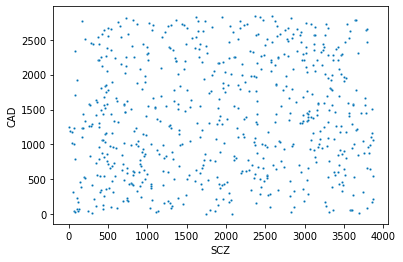

In [45]:
tmp = pd.merge(gprior_results_SCZ[['Rank']], gprior_results_CAD[['Rank']], 
               left_index=True, right_index=True)
tmp.columns = ['SCZ', 'CAD']
sns.scatterplot(data=tmp, x='SCZ', y='CAD', s=5)
#plt.scatter(x=gprior_results_SCZ.iloc[:3000,:].Rank, y=gprior_results_CAD.iloc[:2800,:].Rank)

In [30]:
(gprior_results_SCZ
     .assign(label = lambda df: [int(gene in validation_sets[name]) for gene in df.index])
     .query('label == 1')
     .mean()
)

Probability     81.739250
Rank           178.833333
label            1.000000
dtype: float64

# Experiment 1

In [80]:
gene_sets_SCZ_df = pd.read_excel('Data/Gene Sets.xlsx', sheet_name='Schizophrenia curated', engine='openpyxl')
gene_sets_SCZ_df.head()

,"European GWAS (Pardiñas et al., 2018)","European RVAS (Singh et al., 2020)","European GWAS (Riple et al., 2020)","Asian GWAS (Lam et al., 2019)"
0,DPYD,SETD1A,PCDH17,VRK2
1,ARL3,CUL1,ZNF281,SPATS2L
2,ABCB9,XPO7,PTBP2,RASSF1
3,FES,TRIO,WSCD2,DOCK3
4,LRP1,CACNA1G,TRPC4,STAG1


In [81]:
validation_sets = {}
for name in gene_sets_SCZ_df:
    validation_sets[name] = list(gene_sets_SCZ_df[name].dropna())

In [85]:
for name, valid_set in validation_sets.items():
    print(name)
    print(toppgene_results_SCZ.loc[toppgene_results_SCZ.index.intersection(valid_set)])

European GWAS (Pardiñas et al., 2018)
          Average Score  Rank
CLU            0.348432   188
LRP1           0.282494   234
DGKI           0.272410   279
ADAMTSL3       0.174618   319
ESAM           0.185002   322
ALDOA          0.213896   444
ABCB9          0.247779   534
DPP4           0.202129   551
AKT3           0.228037   576
CDC25C         0.204578   731
FANCL          0.137919   754
DPYD           0.191632   899
CCDC39         0.184775  1124
RERE           0.208605  1151
ARL3           0.177395  1178
FES            0.173277  1588
ANKRD63        0.129577  1711
AMBRA1         0.128974  1789
KDM4A          0.167020  1986
GLT8D1         0.141691  1994
ATXN7          0.113324  2441
BTBD18         0.109296  2466
ANKRD44        0.122913  2510
ANP32E         0.113230  2624
MSL2           0.108375  2950
European RVAS (Singh et al., 2020)
          Average Score  Rank
GRIN2A         0.453373    13
MAGI2          0.414924    49
SV2A           0.332496   198
SP4            0.264828   2

In [69]:
gprior_results_SCZ.loc[gprior_results_SCZ.index.intersection(validation_sets[name])]

,Probability,Rank
SPATS2L,91.1345,29
VRK2,88.6155,71
PITPNM2,86.2665,116
STAG1,85.2907,135
WSCD2,83.9469,159
WBP1L,55.1815,563


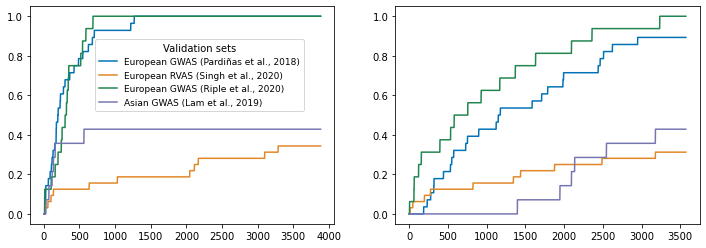

In [102]:
fig, axes = plt.subplots(1,2, figsize=(12,4))

for name, valid_set in validation_sets.items():
    tmp = (gprior_results_SCZ
               .assign(label = lambda df: [int(gene in valid_set) for gene in df.index])
          )
    axes[0].plot(range(1, len(tmp)+1), tmp.label.cumsum() / len(valid_set), label=name)

for name, valid_set in validation_sets.items():
    tmp = (toppgene_results_SCZ
               .assign(label = lambda df: [int(gene in valid_set) for gene in df.index])
          )
    axes[1].plot(range(1, len(tmp)+1), tmp.label.cumsum() / len(valid_set), label=name)

axes[0].legend(prop={'size': 9}, bbox_to_anchor=(0.2,0.5), title='Validation sets')

# Experiment 2

In [87]:
gene_sets_GWAS_df = pd.read_excel('Data/Gene Sets.xlsx', sheet_name='GWAS Catalog', engine='openpyxl')
gene_sets_GWAS_df.head()

,Schizophrenia: Asian GWAS,Schizophrenia: European GWAS,Coronary Artery Disease: Asian GWAS,Coronary Artery Disease: European GWAS
0,COX11P1,RNU7-147P,ALDH2,MRAS
1,HFE,LINC00637,MYL2,PLPP3
2,LINC01648,BTN3A1,MUC22,GGCX
3,MTHFR,LINC01470,COL6A3,MORF4L1
4,PITPNM2,NT5C2,CISD1P1,SMAD3


In [88]:
validation_sets_SCZ = {}
for name in gene_sets_GWAS_df:
    if 'Schizophrenia' in name:
        validation_sets_SCZ[name] = list(gene_sets_GWAS_df[name].dropna())

validation_sets_CAD = {}
for name in gene_sets_GWAS_df:
    if 'Coronary' in name:
        validation_sets_CAD[name] = list(gene_sets_GWAS_df[name].dropna())

In [ ]:
fdff

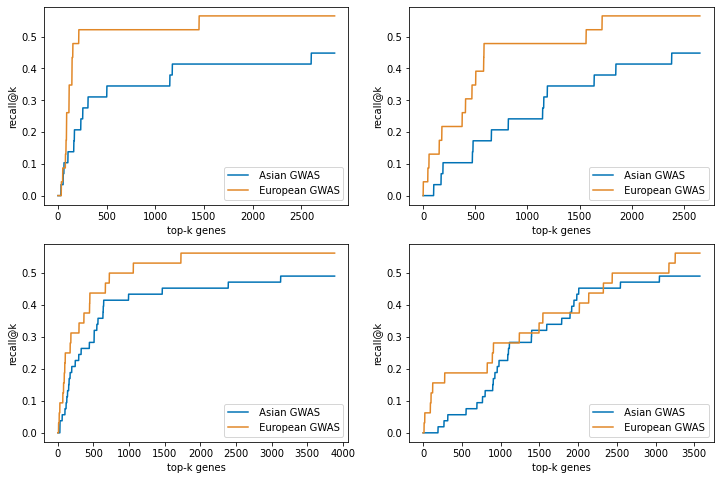

In [106]:
fig, axes = plt.subplots(2,2, figsize=(12,8))

for name, valid_set in validation_sets_CAD.items():
    tmp = (gprior_results_CAD
               .assign(label = lambda df: [int(gene in valid_set) for gene in df.index])
          )
    axes[0,0].plot(range(1, len(tmp)+1), tmp.label.cumsum() / len(valid_set), label=name[name.find(':')+1:])

for name, valid_set in validation_sets_CAD.items():
    tmp = (toppgene_results_CAD
               .assign(label = lambda df: [int(gene in valid_set) for gene in df.index])
          )
    axes[0,1].plot(range(1, len(tmp)+1), tmp.label.cumsum() / len(valid_set), label=name[name.find(':')+1:])

for name, valid_set in validation_sets_SCZ.items():
    tmp = (gprior_results_SCZ
               .assign(label = lambda df: [int(gene in valid_set) for gene in df.index])
          )
    axes[1,0].plot(range(1, len(tmp)+1), tmp.label.cumsum() / len(valid_set), label=name[name.find(':')+1:])

for name, valid_set in validation_sets_SCZ.items():
    tmp = (toppgene_results_SCZ
               .assign(label = lambda df: [int(gene in valid_set) for gene in df.index])
          )
    axes[1,1].plot(range(1, len(tmp)+1), tmp.label.cumsum() / len(valid_set), label=name[name.find(':')+1:])

for row in axes:
    for ax in row:
        ax.set(xlabel='top-k genes', ylabel='recall@k')
        ax.legend(loc=4)